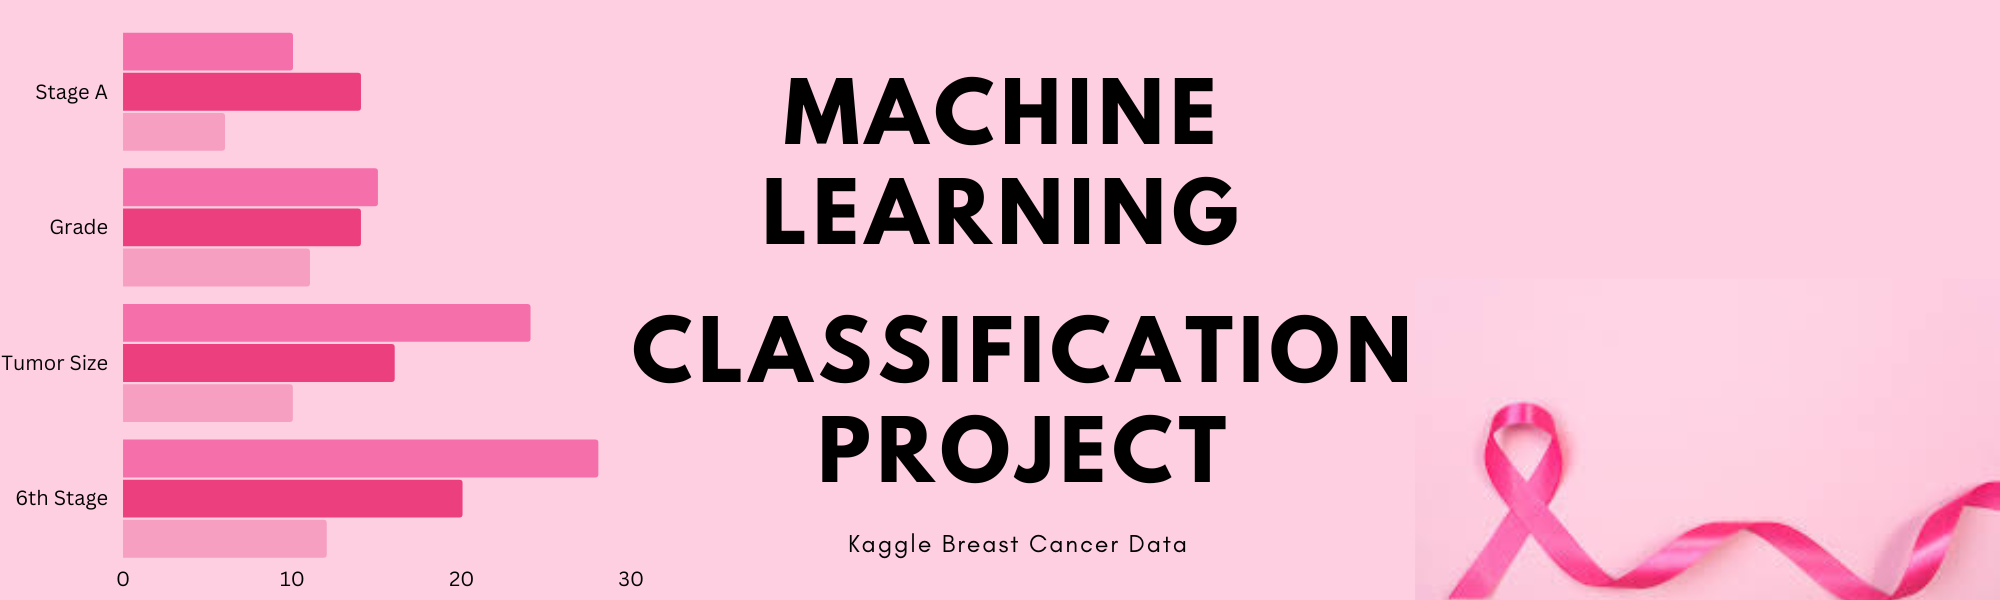

# <center><b>Predicitng the Grade</b></center>


<span style="color:pink">In this Notebook I will use a variety of models to predcit the grade of the patient. <br>
* In the original data the grade column is ordinal from 1 to 4.<br>
* the eda shows that imblanced, high volume of grade number 2 with less 1 and 3. also, a very mninmal amount of 4's.
* I will use be using a data auggmentation method called: SMOTE to syntheticly oversampled classes 1 & 3
* after consideration and to avoid overfitting, we will not try to predict grade 4 and will delete the patients with this grade from our data.
 </br></span>

# Import Libaries

In [1]:
## install libraries
# %pip install imbalanced-learn
# %pip install xgboost

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from cancer_func import cancer_encode
from cancer_func import cancer_features_select

from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
%matplotlib inline

# Data Observation

In [3]:
df = pd.read_csv('Breast_Cancer.csv')
df_copy = df.copy()
cancer_encoder = FunctionTransformer(cancer_encode, validate=False)
cancer_features_selector = FunctionTransformer(cancer_features_select, validate=False)
df = cancer_encode(df)
df = cancer_features_select(df)
df.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,...,Marital Status_Single,Marital Status_Widowed,6th Stage_IIA,6th Stage_IIB,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,Regional_Node_pos_%,Estrogen&Progesterone positive,Estrogen&Progesterone Negative
0,68,0.0,0.0,0.0,3.0,0.0,4,1.0,1.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.166667,1.0,0.0
1,50,1.0,1.0,2.0,2.0,0.0,35,1.0,1.0,14,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.714286,1.0,0.0
2,58,2.0,2.0,4.0,2.0,0.0,63,1.0,1.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,1.0,0.0
3,58,0.0,0.0,0.0,3.0,0.0,18,1.0,1.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.000000,1.0,0.0
4,47,1.0,0.0,1.0,3.0,0.0,41,1.0,1.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33.333333,1.0,0.0


Class=3.0, Count=1111, Percentage=27.609%
Class=2.0, Count=2351, Percentage=58.424%
Class=1.0, Count=543, Percentage=13.494%
Class=4.0, Count=19, Percentage=0.472%


<BarContainer object of 4 artists>

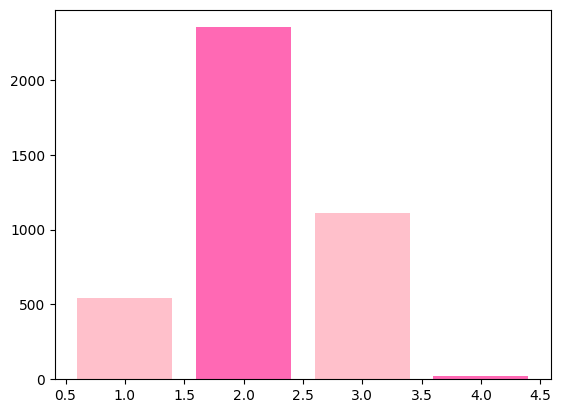

In [4]:
#plot the distribution before smote 
counter = Counter(df.Grade)
colors = ['#FFC0CB', '#FF69B4']  # Pinkish colors
for k,v in counter.items():
    per = v / len(df.Grade) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per)) 
plt.bar(counter.keys(), counter.values(), color=colors)

# Simple Models Pipeline

## Data Prepocessing

In [5]:
#delete class 4
#df = df.drop(df[df['Grade'] == 4.0].index)
#split to train and test
#split to x and y
X = df.drop('Grade', axis=1)
y= df['Grade']

#split to train and test 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode the target variable
#le = LabelEncoder()
#y_train_encoded = le.fit_transform(y_train)
#y_test_encoded = le.transform(y_test)

Class=3.0, Count=1111, Percentage=27.609%
Class=2.0, Count=2351, Percentage=58.424%
Class=1.0, Count=543, Percentage=13.494%
Class=4.0, Count=19, Percentage=0.472%


<BarContainer object of 4 artists>

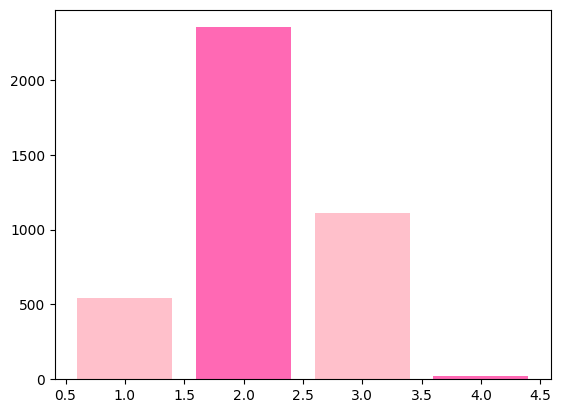

In [6]:
#plot the distribution before smote 
counter = Counter(df.Grade)
colors = ['#FFC0CB', '#FF69B4']  # Pinkish colorsc
for k,v in counter.items():
    per = v / len(df.Grade) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per)) 
plt.bar(counter.keys(), counter.values(), color=colors)

In [7]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),

}


# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids
param_grids = {
    'Logistic Regression': {
                            'smote__sampling_strategy': [{1:1000,3:1000},{1:900,3:2000}],
                            "smote__k_neighbors": [15,9], "model__class_weight":[{1:2,2:1,3:3},{1:2,2:1,3:4},{1:2,2:1,3:2}]},
    'Decision Tree': {'model__max_depth': [ 6, 7, 8],'smote__sampling_strategy': [{1:1000,3:1000},{1:900,3:2000}]}
}
X_train =X_train[y_train!=4]
y_train = y_train[y_train!=4]
# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

Model: Logistic Regression
Best parameters: {'model__class_weight': {1: 2, 2: 1, 3: 2}, 'smote__k_neighbors': 15, 'smote__sampling_strategy': {1: 1000, 3: 1000}}
Cross-validation scores: [0.33415904 0.30967399 0.29901667 0.29004414 0.32962259]
Classification report:
              precision    recall  f1-score   support

         1.0       0.18      0.60      0.27       109
         2.0       0.66      0.24      0.35       470
         3.0       0.41      0.49      0.45       222
         4.0       0.00      0.00      0.00         4

    accuracy                           0.36       805
   macro avg       0.31      0.33      0.27       805
weighted avg       0.52      0.36      0.37       805

-----------------------------

Model: Decision Tree
Best parameters: {'model__max_depth': 7, 'smote__sampling_strategy': {1: 1000, 3: 1000}}
Cross-validation scores: [0.35991908 0.3550393  0.38642143 0.33091526 0.41493476]
Classification report:
              precision    recall  f1-score   suppor

In [8]:
# %pip install yellowbrick

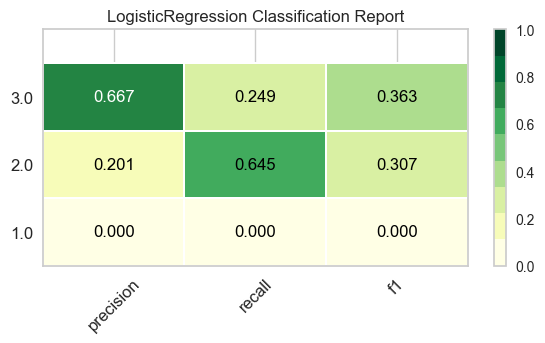

Model: Logistic Regression
Classification report:
              precision    recall  f1-score   support

         1.0       0.17      0.57      0.26       109
         2.0       0.65      0.23      0.34       470
         3.0       0.41      0.50      0.45       222
         4.0       0.00      0.00      0.00         4

    accuracy                           0.35       805
   macro avg       0.31      0.33      0.26       805
weighted avg       0.51      0.35      0.36       805

-----------------------------



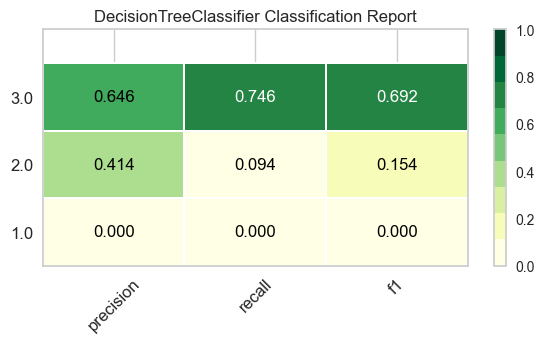

Model: Decision Tree
Classification report:
              precision    recall  f1-score   support

         1.0       0.42      0.07      0.12       109
         2.0       0.61      0.73      0.66       470
         3.0       0.40      0.40      0.40       222
         4.0       0.00      0.00      0.00         4

    accuracy                           0.55       805
   macro avg       0.36      0.30      0.30       805
weighted avg       0.52      0.55      0.51       805

-----------------------------



In [9]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport

def visualize_model(X, y, estimator, **kwargs):
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, classes=[1.0, 2.0, 3.0, 4.0],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    visualize_model(X_train, y_train, best_model)

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)
    print(f"Model: {model_name}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")


# Ensmble Methods Training

In [10]:
df= df_copy 
cancer_encoder = FunctionTransformer(cancer_encode, validate=False)
cancer_features_selector = FunctionTransformer(cancer_features_select, validate=False)
df = cancer_encode(df)
df = cancer_features_select(df)
df.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,...,Marital Status_Single,Marital Status_Widowed,6th Stage_IIA,6th Stage_IIB,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,Regional_Node_pos_%,Estrogen&Progesterone positive,Estrogen&Progesterone Negative
0,68,0.0,0.0,0.0,3.0,0.0,4,1.0,1.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.166667,1.0,0.0
1,50,1.0,1.0,2.0,2.0,0.0,35,1.0,1.0,14,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.714286,1.0,0.0
2,58,2.0,2.0,4.0,2.0,0.0,63,1.0,1.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,1.0,0.0
3,58,0.0,0.0,0.0,3.0,0.0,18,1.0,1.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.000000,1.0,0.0
4,47,1.0,0.0,1.0,3.0,0.0,41,1.0,1.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33.333333,1.0,0.0


In [11]:
#delete class 4
df = df.drop(df[df['Grade'] == 4.0].index)
#split to train and test
#split to x and y
X = df.drop('Grade', axis=1)
y= df['Grade']
#split to train and test 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Class=3.0, Count=1111, Percentage=27.740%
Class=2.0, Count=2351, Percentage=58.702%
Class=1.0, Count=543, Percentage=13.558%


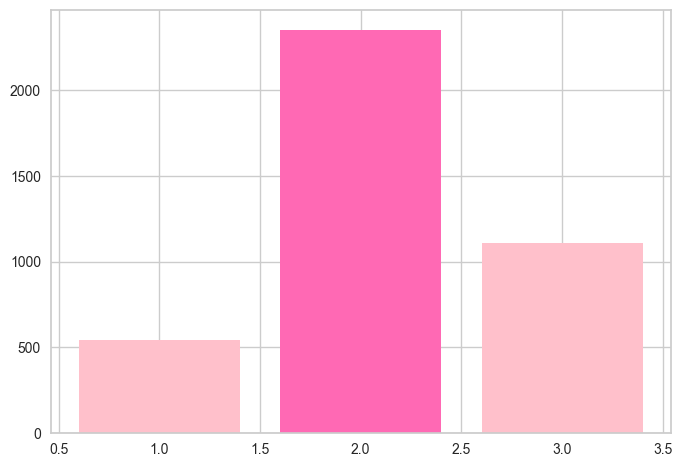

In [12]:
#plot the distribution before smote 
counter = Counter(df.Grade)
colors = ['#FFC0CB', '#FF69B4']  # Pinkish colors

for k, v in counter.items():
    per = v / len(df.Grade) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

plt.bar(counter.keys(), counter.values(), color=colors)
plt.show()

In [13]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(n_estimators=600)
}
y_train =y_train.astype(str)
y_test=y_test.astype(str)

# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids for each model
param_grids = {
    'Random Forest': {'model__n_estimators': [100, 200, 300]},
    'XGBoost': {'model__n_estimators': [100, 200, 300],'smote__sampling_strategy': [{'1':1000,'3':1000},{'1':900,'3':2000}]}
}

# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 339, in _fit
    self._validate_steps()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 230, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE()' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't


In [ ]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport

def visualize_model(X, y, estimator, **kwargs):
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, classes=[1.0, 2.0, 3.0, 4.0],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    visualize_model(X_train, y_train, best_model)

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)
    print(f"Model: {model_name}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

In [ ]:
from cancer_func import cancer_encode
from cancer_func import cancer_features_select
from cancer_func import cancer_encoder
from cancer_func import cancer_features_selector
from cancer_func import report, cross_validation_report
from cancer_func import cancer_encode_without_ms

In [ ]:
y

In [ ]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['Grade'], axis=1, inplace=False) #sould be without  
y = df['Grade']
y =y.astype(int)
y = y -1
XGB = XGBClassifier(n_estimators=450)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    'over__sampling_strategy': [{0:1000,2:1000},{0:900,2:2000}],
    "over__k_neighbors": [15,9],
    "XGB__max_depth": [3,4],
    #"XGB__scale_pos_weight": [10,50],
    #'XGB__subsample': [1.0],
    #"XGB__colsample_bytree": [1.0],
    "XGB__gamma":[2,3],
    "XGB__learning_rate":[0.05,0.01],
}
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring='f1_macro')
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

In [ ]:
unique_classes = np.unique(y_train)
print(unique_classes)

In [ ]:
print(report(XGB_search, X, y))

In [ ]:
#plot the distribution after smote 
counter = Counter(y_train)
colors = ['#FFC0CB', '#FF69B4']  # Pinkish colors
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per)) 
plt.bar(counter.keys(), counter.values(), color=colors)